# Predicting Fraud

### On `Mobile money` transactions for `Mara Bank`

## Sections in this notebook.


- Introduction
    - Project Overview
    - Objectives
    - Dataset Background

- Data Importation
    - Loading Required Libraries
    - Reading Data Files
    - Initial Data Preview

- Data Normalization
    - Feature Encoding
    - Feature Normilization
    

- Model Training
    - Pick Models
    - Split Data
    - Training

- Initial Evaluation
    - Cross Validation
    - Classification Report

- Fine Tuning
    - Initialize Parameters
    - Random Tuning
    - Grid Tuning

- Final Evaluation
    - Fit & Predict
    - Evaluation

- Insights and Findings
    - Key Patterns
    - Anomalies
    - Business Insights
    - Recommendations

## Introduction

- Project Overview
- Objectives
- Dataset Background

### Project Overview

Every second, Mara Bank’s mobile money platform processes countless transactions, airtime top-ups, utility bill payments, and peer-to-peer transfers; flowing across Nigeria.

But hidden within this stream are fraudulent attempts: some subtle, others blatant. Fraudsters exploit timing gaps, customer behavior, and even system trust. Spotting them in real-time requires not just rules but predictive intelligence.

This project is about building a fraud prediction model that learns from historical transactions to detect and flag suspicious activity before it spreads.

### Project Objective

The Key objectives are:

- Detect anomalies at scale: Use transaction history to identify deviations from normal user and network behavior.

- Develop predictive features: Incorporate transaction patterns, velocity, amounts, geolocation, and device data that highlight fraud signals.

- Train robust models: Experiment with machine learning algorithms (tree-based models, gradient boosting) to capture both simple and complex fraud patterns.

- Evaluate with precision: Prioritize recall and precision in performance metrics — missing fraud is costly, but so is flagging too many genuine users.

- Enable real-time inference: Prepare the model for deployment so Mara Bank can flag or block fraudulent activities instantly as they occur.

The ultimate goal: predict fraudulent transactions with high accuracy, minimizing financial loss while maintaining customer trust.

### Background of Dataset

The dataset was generated mimicing the different scenerios transactions can occur in Nigeria. It contains transactions of diferrent banks, however we will be focusing on the transactions that belongs to `Mara Bank` for this project.

This dataset contains the following:

- `amount`: The value of the transaction.
- `balance`: The account balance after the transaction.
- `time`: The timestamp of the transaction.
- `holder`: The account number of the transaction's initiator or recipient.
- `kyc`: The kyc level of the account
- `holder_bvn`: The BVN of the transaction's initiator or recipient.
- `holder_bank`: The bank of the related party.
- `related`: The account number or entity related to the transaction (e.g., recipient account, ATM bank).
- `related_bvn`: The BVN of the related party.
- `related_bank`: The bank of the related party.
- `state`, `latitude`, `longitude`: Location details of the transaction.
- `status`: The outcome of the transaction (e.g., 'SUCCESS', 'FAILED').
- `type`: The transaction type (e.g., 'DEBIT', 'CREDIT').
- `category`: The specific class of transaction (e.g., 'OPENING', 'WITHDRAWAL', 'PAYMENT', 'TRANSFER', 'REVERSAL', 'BILL').
- `channel`: The channel used for the transaction (e.g., 'CARD', 'APP', 'USSD').
- `device`: The device used for the transaction (e.g., 'ATM-001', 'MOBILE-003') .
- `nonce`: A unique identifier for related transactions.
- `reported`: Marks reported transactions?

## Data Importation

- Loading Required Libraries
- Reading Data Files
- Initial Data Preview

### Loading required libraries

In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# Import modules

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.preprocessing import RobustScaler
import joblib
from datetime import  datetime

In [74]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [75]:
from lib import oracle, engineer, analyst

### Reading data files

In [76]:
# Load the transactions dataset for the project 
df = pd.read_csv('../datasets/classified_transactions.csv')

### Initial data preview

In [77]:
# Preview the dataset
df.head()

,amount,balance,holder,holder_bvn,related,related_bvn,related_bank,state,latitude,longitude,...,unsual_balance_score,unsual_balance,unsual_location_score,unsual_location,unsual_time_score,unsual_time,unsual_device_score,unsual_device,fraud_score,fraud
0,2.795174,0.022737,-0.614232,-0.723333,0.38287,-0.258966,-0.666667,-0.111111,0.611530,-0.287418,...,0.921375,True,0.0,False,0.0,False,0.633838,True,0.582712,True
1,3.869970,0.091545,-0.610487,-0.716667,0.38287,-0.258966,-0.666667,-0.666667,0.687933,-0.112631,...,0.949439,True,0.0,False,0.0,False,0.633838,True,0.724226,True
2,1.382899,-0.067677,-0.602996,-0.640000,0.38287,-0.258966,-0.666667,-0.944444,-0.607447,-0.089852,...,0.849398,True,0.0,False,0.0,False,0.633838,True,0.548273,True
3,0.281568,-0.138184,-0.599251,-0.623333,0.38287,-0.258966,-0.666667,-0.555556,0.235119,0.063936,...,0.743064,True,0.0,False,0.0,False,0.633838,True,0.403299,False
4,0.361870,-0.133043,-0.595506,-0.596667,0.38287,-0.258966,-0.666667,0.055556,0.992357,1.027152,...,0.765919,True,0.0,False,0.0,False,0.633838,True,0.417689,False


In [78]:
# The basic information about the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18125 entries, 0 to 18124
Columns: 129 entries, amount to fraud
dtypes: bool(6), float64(123)
memory usage: 17.1 MB


In [79]:
# The shape of the dataset
df.shape

(18125, 129)

## Model Training

In [80]:
SEED = 42

### Model Selection

We will using the following regression estimators as starting point, then select the best and cross validate with them.

In [81]:
train_models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'XGBRegressor': XGBRegressor(),
    'XGBRFRegressor': XGBRFRegressor()
}

In [82]:
X = df.drop(['fraud_score', 'fraud'], axis=1)
y = df['fraud_score']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=.2)

In [84]:
oracle.train_score_models(models=train_models, seed=SEED, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

RandomForestRegressor scored: 0.9281682406233632
LinearRegression scored: 0.9580291023914221
DecisionTreeRegressor scored: 0.8203938343464962
XGBRegressor scored: 0.9652087249032867
XGBRFRegressor scored: 0.8036936854947714


Out of the 5 estimators, We will continue the cross validation with the top 3.

Which are XGBRegressor, XGBRFRegressor and RandomForestRegressor

In [85]:
cross_val_models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LinearRegression': LinearRegression()
}

Let's score them using `R2`, it checks if our prediction is following the pattern of the actual values. The closer to 1 the better.

In [86]:
oracle.crossval_models(models=cross_val_models, scoring='r2', seed=SEED, X=X, y=y)

RandomForestRegressor mean: 0.8920632646435169, std: 0.0171671527297685
XGBRegressor mean: 0.9336091368301453, std: 0.019183900102817782
LinearRegression mean: -32.90478671771275, std: 67.71309854745743


XGBRegressor is the best with respect to `r2` scoring.

Let's score them using `neg_mean_squared_error`, this is the average of the square of our error in predicting, the smaller the better.

In [87]:
oracle.crossval_models(models=cross_val_models, scoring='neg_mean_squared_error', seed=SEED, X=X, y=y)

RandomForestRegressor mean: -0.0022419672108924048, std: 0.00016493308595253456
XGBRegressor mean: -0.0013625895910223834, std: 0.00025996879947576035
LinearRegression mean: -0.5978235818571143, std: 1.1935461226057653


XGBRegressor is the best with respect to `neg_mean_squared_error` scoring.

Let's score them using `neg_root_mean_squared_error`, this is the root average of the square of our error in predicting, the smaller the better.

In [88]:
oracle.crossval_models(models=cross_val_models, scoring='neg_root_mean_squared_error', seed=SEED, X=X, y=y)

RandomForestRegressor mean: -0.04731656439507157, std: 0.001763503541093855
XGBRegressor mean: -0.036745618886725104, std: 0.0035141263002252325
LinearRegression mean: -0.37141472360116073, std: 0.6781406085388101


XGBRegressor is the best with respect to `neg_root_mean_squared_error` scoring.

Let's score them using `neg_median_absolute_error`, this is the median of the errors we made (Squared), the smaller the better.

In [89]:
oracle.crossval_models(models=cross_val_models, scoring='neg_median_absolute_error', seed=SEED, X=X, y=y)

RandomForestRegressor mean: -0.0245957854638141, std: 0.001317282002872745
XGBRegressor mean: -0.018927952037874334, std: 0.0018270971181057764
LinearRegression mean: -0.4732062724666773, std: 0.9066375804387566


XGBRegressor is the best with respect to `neg_median_absolute_error` scoring.

In general, it is obvious that `XGBRegressor` is best option already in all the scorings.

Let's tune our parameters, just to be very sure. 

So we will tune the `RandomForestRegressor` and `XGBRegressor` estimators.

## Parameter Tuning

Here are our params

In [90]:
rf_params = {
    "n_estimators": [50, 100],             # fewer trees for speed
    "max_depth": [None, 10],               # shallow vs unlimited
    "min_samples_split": [2, 5],           # low vs higher split
    "min_samples_leaf": [1, 2],            # low vs higher leaf
    "max_features": ["sqrt"],              # keep it simple
    "bootstrap": [True],                   # avoid both True/False for speed
    "criterion": ["squared_error"]         # stick with the standard
}

# --- XGBRegressor (Reduced) ---
xgbr_params = {
    "n_estimators": [50, 100, 200],        # cut down boosting rounds
    "learning_rate": [0.05, 0.1],          # common values
    "max_depth": [3, 5],                   # shallow vs medium
    "min_child_weight": [1, 3],            # flexible
    "subsample": [0.8, 1.0],               # avoid too many values
    "colsample_bytree": [0.8],             # fixed for testing
    "gamma": [0, 0.1],                     # lightweight
    "reg_alpha": [0, 0.1],                 # light L1 regularization
    "reg_lambda": [1]                      # standard L2
}

Let's do a random search to determine the best estimator with random parameters.

In [91]:
random_models = [
    ('RandomForestRegressor', RandomForestRegressor(), rf_params),
    ('XGBRegressor', XGBRegressor(), xgbr_params)
]

In [92]:
random_search = oracle.random_search(models=random_models, X=X, y=y, n_iter=10)

RandomForestRegressor best score: 0.9009857173597109 scored by r2
XGBRegressor best score: 0.9462811820848108 scored by r2


In [93]:
grid_models = [
   ('XGBRegressor', XGBRegressor(), xgbr_params),
]

In [94]:
grid_search = oracle.grid_search(models=grid_models, X=X, y=y)

XGBRegressor best score: 0.9512224979595143 scored by r2


In [98]:
best_model = grid_search[0]['Best Estimator']

Text(0.5, 1.0, 'Feature Importances')

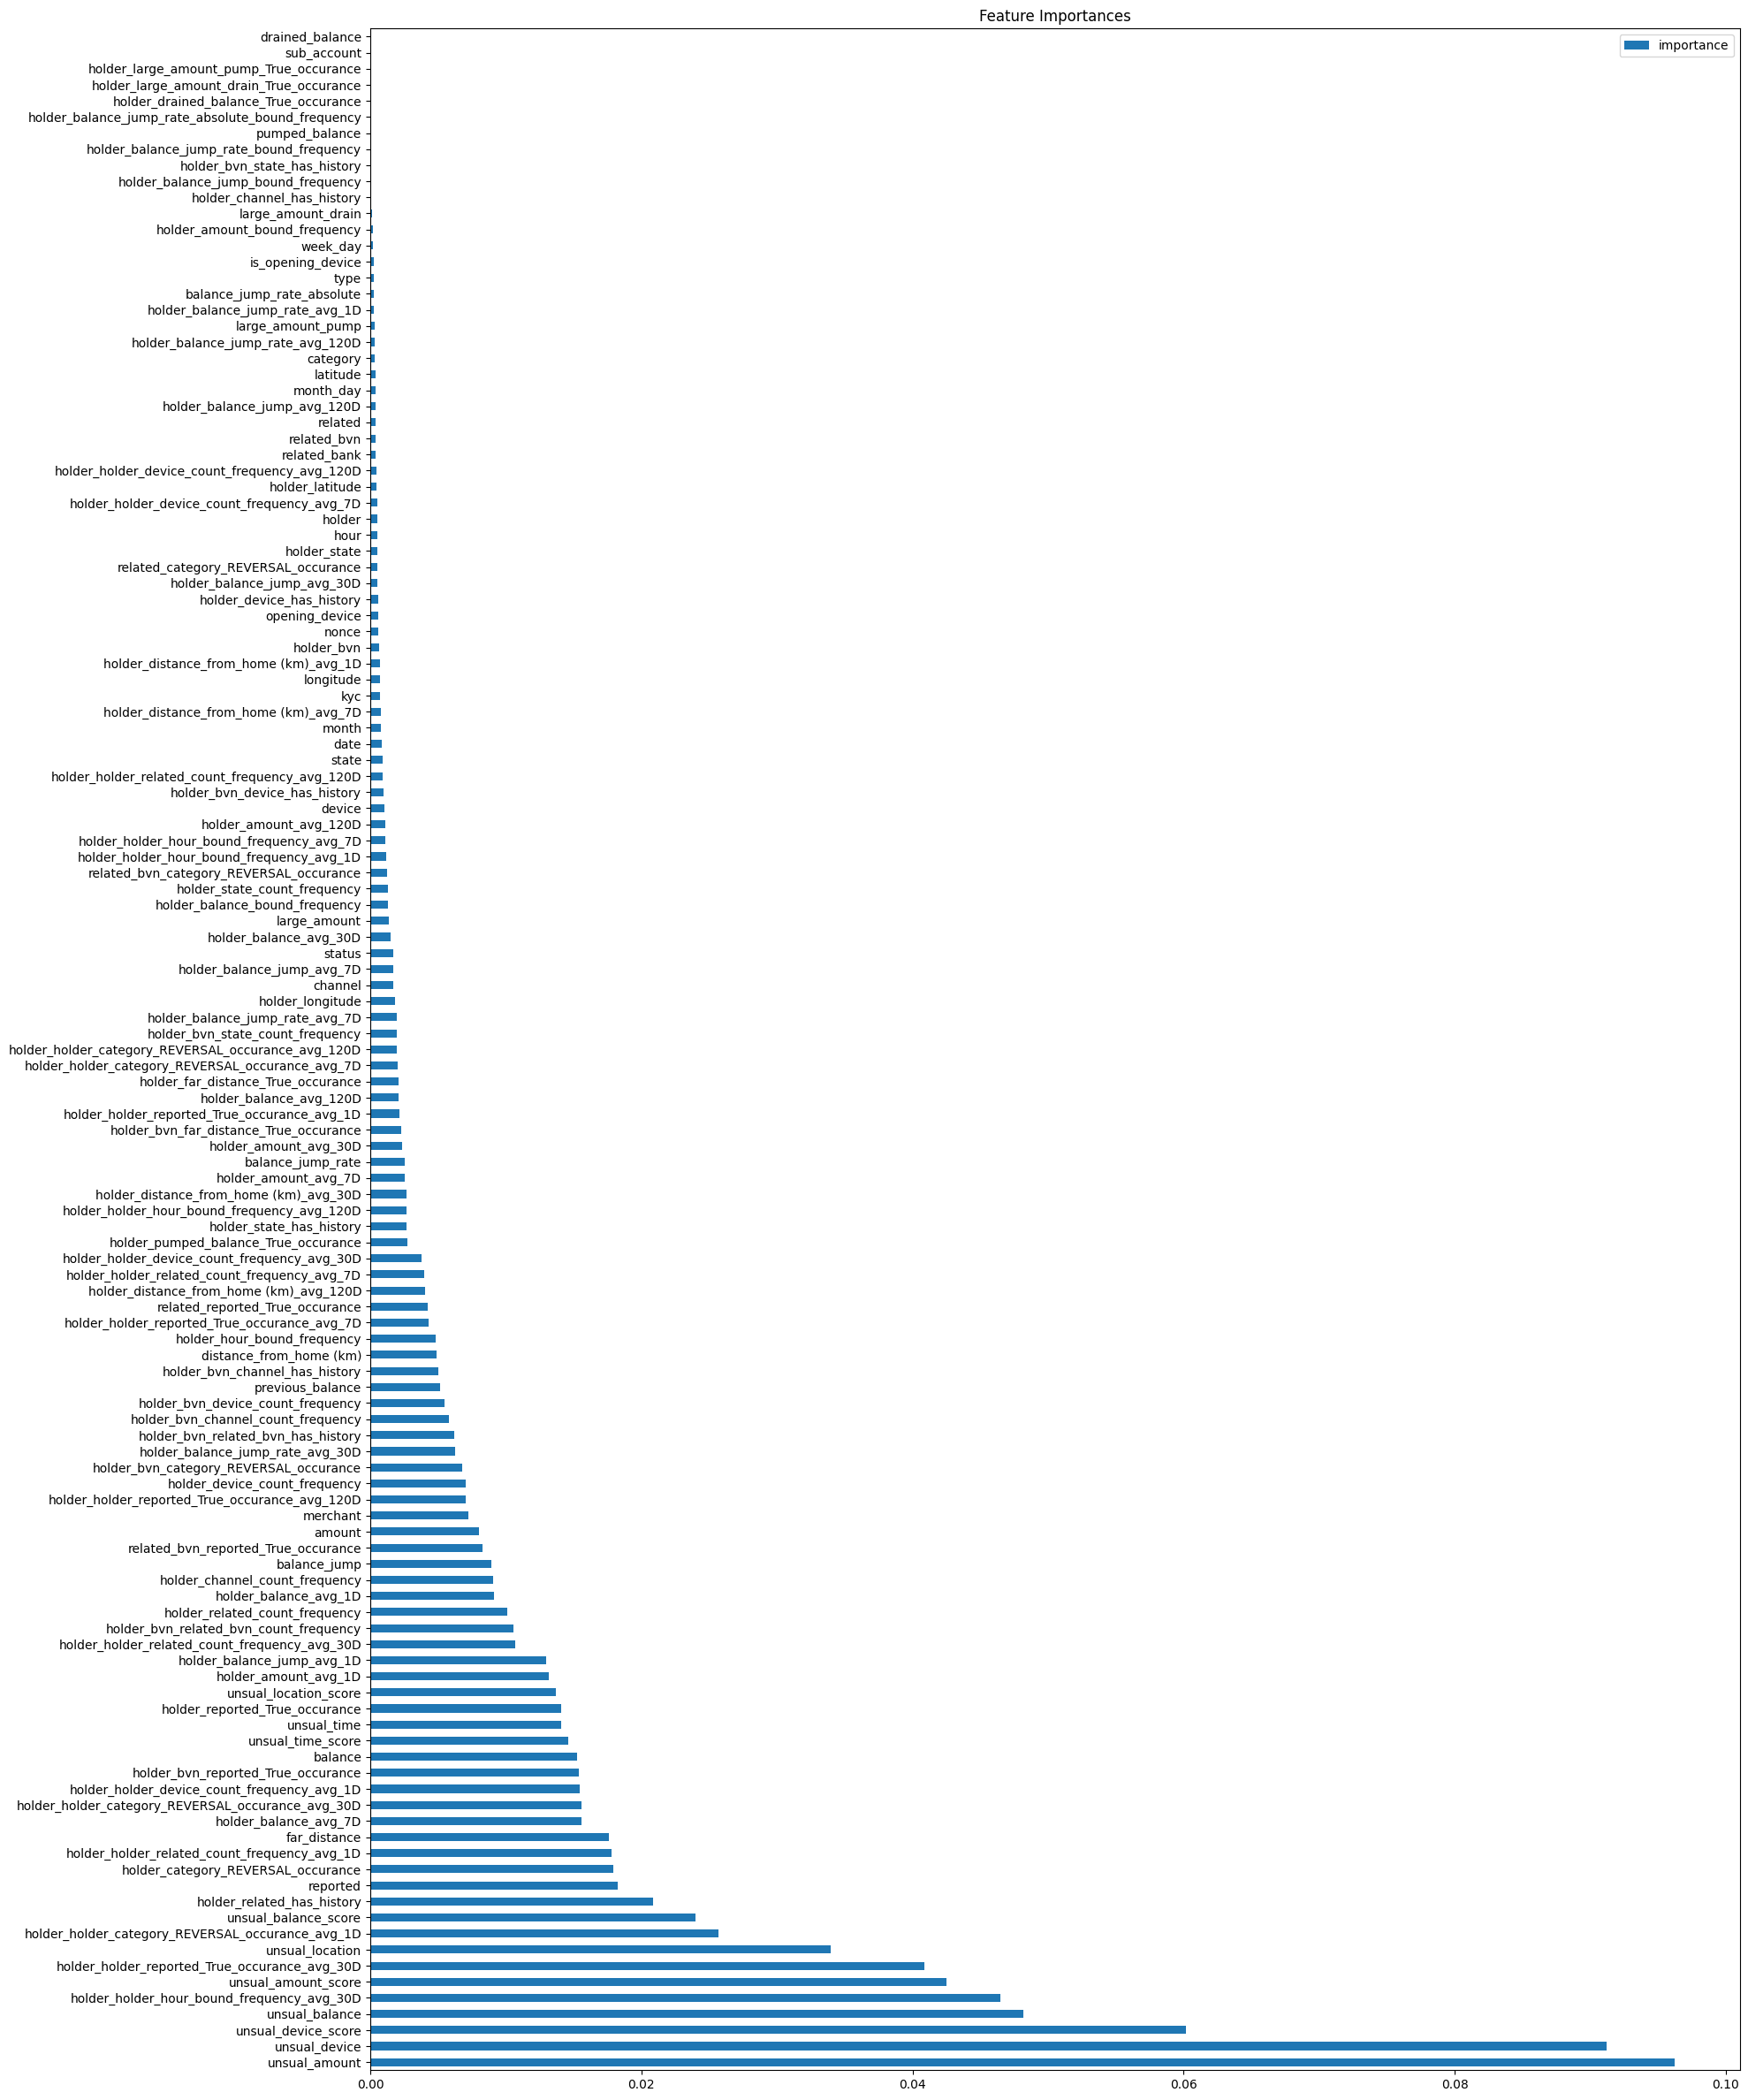

In [104]:
# Create a dataframe to store the feature importances
feature_importances = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Visualize the feature importances
feature_importances.plot.barh(figsize=(20, 30))
plt.title('Feature Importances')

In [ ]:
# Save the model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(best_model, f"../models/predict_fraud_score_model_{timestamp}")

['../models/predict_fraud_score_model_20250907_191011']